<a href="https://colab.research.google.com/github/vanessamenta/churn/blob/master/Un_benvenuto_a_Colaboratory_obes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data science

Con Colab puoi sfruttare tutta la potenza delle librerie Python per analizzare e visualizzare i dati. La seguente cella di codice usa <strong>numpy</strong> per generare alcuni dati casuali e usa <strong>matplotlib</strong> per visualizzarli. Per modificare il codice, fai clic sulla cella e inizia a modificare.

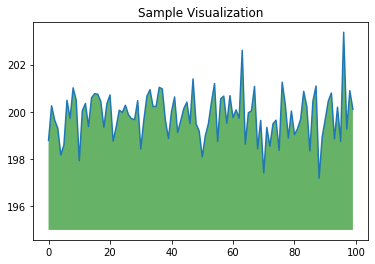

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)

plt.title("Sample Visualization")
plt.show()

In [3]:
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_csv(io.BytesIO(uploaded['data.csv']))

Saving data.csv to data.csv


In [7]:

bmi=data.loc[data['Type'] == 3]

Puoi importare i tuoi dati nei blocchi note Colab dal tuo account Google Drive, inclusi i fogli di lavoro, da GitHub e molte altre fonti. Per ulteriori informazioni sull'importazione dei dati e sulle possibilità di utilizzo di Colab per la data science, vedi i link di seguito, sotto <a href="#working-with-data">Utilizzo dei dati</a>.

In [8]:
bmi_obeso= bmi.loc[bmi['Value'] > 30]

In [9]:
print(bmi_obeso)

         Unnamed: 0  Utente  Sex  Age  Height        Date  Type  Value
3948           3948    8002    1   48     167  2016-07-04     3  31.43
3969           3969    8002    1   48     167  2016-07-10     3  30.81
3986           3986    8002    1   48     167  2016-07-15     3  30.77
4010           4010    8002    1   48     167  2016-07-24     3  30.37
5523           5523   11321    1   55     179  2016-12-29     3  42.42
...             ...     ...  ...  ...     ...         ...   ...    ...
7595664     7595664   10793    1   47     183  2017-01-26     3  32.26
7595670     7595670   10793    1   47     183  2017-01-27     3  31.92
7595678     7595678   10793    1   47     183  2017-01-29     3  32.00
7595690     7595690   10793    1   47     183  2017-02-01     3  32.27
7595722     7595722   10793    1   47     183  2017-02-10     3  32.05

[102815 rows x 8 columns]


In [12]:
import random
import numpy as np
from itertools import product


def _check_param(values):
    
    """
    Check the parameter boundaries passed in dict values.
    
    Returns
    -------
    list of checked parameters.
    """

    if isinstance(values, (list,tuple,np.ndarray)):
        return list(set(values))
    elif hasattr(values, 'rvs'):
        return values
    else:
        return [values]


def _safeformat_str(str, **kwargs):
    
    """
    Safe naming formatting for 'trial' and 'fold' token.
    
    Returns
    -------
    string filled correctly.
    """
    
    class SafeDict(dict):
        def __missing__(self, key):
            return '{' + key + '}'
    
    replacements = SafeDict(**kwargs)
    
    return str.format_map(replacements)


def _get_callback_paths(callbacks):
    
    """
    Extract the saving paths of Keras callbacks that allow the
    possibility to create external files.
    
    Returns
    -------
    list of extracted paths.
    """
    
    paths = []
    
    if isinstance(callbacks, list):
        for c in callbacks:
            if hasattr(c, 'filepath'):
                paths.append(c.filepath)
            elif hasattr(c, 'log_dir'):
                paths.append(c.log_dir)
            elif hasattr(c, 'filename'):
                paths.append(c.filename)
            elif hasattr(c, 'path'):
                paths.append(c.path)
            elif hasattr(c, 'root'):
                paths.append(c.root)
            else:
                paths.append(None)
    else:
        if hasattr(callbacks, 'filepath'):
            paths.append(callbacks.filepath)
        elif hasattr(callbacks, 'log_dir'):
            paths.append(callbacks.log_dir)
        elif hasattr(callbacks, 'filename'):
            paths.append(callbacks.filename)
        elif hasattr(callbacks, 'path'):
            paths.append(callbacks.path)
        elif hasattr(callbacks, 'root'):
            paths.append(callbacks.root)
        else:
            paths.append(None)
            
    return paths


def _clear_callbacks(callbacks, paths, trial, fold, start_score):
    
    """
    Assign the correct saving path to callbacks (if needed) and
    restore the starting score.
    
    Returns
    -------
    list of callbacks.
    """
    
    if not isinstance(callbacks, list):
        callbacks = [callbacks]
    
    for i,c in enumerate(callbacks):
        if hasattr(c, 'filepath'):
            c.filepath = _safeformat_str(paths[i], 
                                         trial=trial, fold=fold)
        elif hasattr(c, 'log_dir'):
            c.log_dir = _safeformat_str(paths[i], 
                                        trial=trial, fold=fold)
        elif hasattr(c, 'filename'):
            c.filename = _safeformat_str(paths[i], 
                                         trial=trial, fold=fold)
        elif hasattr(c, 'path'):
            c.path = _safeformat_str(paths[i], 
                                     trial=trial, fold=fold)
        elif hasattr(c, 'root'):
            c.root = _safeformat_str(paths[i], 
                                     trial=trial, fold=fold)
        if hasattr(c, 'best'):
            c.best = start_score

    return callbacks


def _create_fold(X, ids):
    
    """
    Create folds from the data received.
    
    Returns
    -------
    arrays/list or array/dict of arrays containing fold data.
    """
    
    if isinstance(X, list):
        return [x[ids] for x in X]
    
    elif isinstance(X, dict):
        return {k:v[ids] for k,v in X.items()}
    
    else:
        return X[ids]
    

def _check_data(X):
    
    """
    Data controls for cross validation.
    """
    
    if isinstance(X, list):
        for x in X:
            if not isinstance(x, np.ndarray):
                raise ValueError(
                    "Received data in list format. If you are dealing with "
                    "multi-input or multi-output model, take care to cast each "
                    "element of the list to numpy array. In case of single-input or "
                    "single-output, list are not supported: cast them to numpy array.")
    
    elif isinstance(X, dict):
        for x in X.values():
            if not isinstance(x, np.ndarray):
                raise ValueError(
                    "Received data in dict format. Take care to cast each "
                    "value of the dict to numpy array.")
                
    elif isinstance(X, np.ndarray):
        pass
    
    else:
        raise ValueError(
            "Data format not appropriate for Keras CV search. "
            "Supported types are list, dict or numpy array.")
        
        

class ParameterSampler(object):

    # modified from scikit-learn ParameterSampler
    """
    Generator on parameters sampled from given distributions.
    Non-deterministic iterable over random candidate combinations for hyper-
    parameter search. If all parameters are presented as a list,
    sampling without replacement is performed. If at least one parameter
    is given as a distribution, sampling with replacement is used.
    It is highly recommended to use continuous distributions for continuous
    parameters.
    
    Parameters
    ----------
    param_distributions : dict
        Dictionary with parameters names (`str`) as keys and distributions
        or lists of parameters to try. Distributions must provide a ``rvs``
        method for sampling (such as those from scipy.stats.distributions).
        If a list is given, it is sampled uniformly.
        If a list of dicts is given, first a dict is sampled uniformly, and
        then a parameter is sampled using that dict as above.
    n_iter : integer
        Number of parameter settings that are produced.
    random_state : int, default None
        Pass an int for reproducible output across multiple
        function calls.
    
    Returns
    -------
    param_combi : list of tuple
        list of sampled parameter combination
    """

    def __init__(self, param_distributions, n_iter, random_state=None):
        
        self.n_iter = n_iter
        self.random_state = random_state
        self.param_distributions = param_distributions

    def __init__(self, param_distributions, n_iter, random_state=None):
        
        self.n_iter = n_iter
        self.random_state = random_state
        self.param_distributions = param_distributions

    def sample(self):
        
        self.param_distributions = self.param_distributions.copy()
        
        for p_k, p_v in self.param_distributions.items():
            self.param_distributions[p_k] = _check_param(p_v)
         
        all_lists = all(not hasattr(p, "rvs") 
                        for p in self.param_distributions.values())
            
        seed = (random.randint(1, 100) if self.random_state is None 
                else self.random_state+1)
        random.seed(seed)
        
        if all_lists:
            param_combi = list(product(*self.param_distributions.values()))
            grid_size = len(param_combi)

            if grid_size < self.n_iter:
                raise ValueError(
                    f"The total space of parameters {grid_size} is smaller "
                    f"than n_iter={self.n_iter}. Try with KerasGridSearch.")
            param_combi = random.sample(param_combi, self.n_iter)

        else:
            param_combi = []
            k = self.n_iter
            for i in range(self.n_iter):
                dist = self.param_distributions
                params = []
                for j,v in enumerate(dist.values()):
                    if hasattr(v, "rvs"):
                        params.append(v.rvs(random_state=seed*(k+j)))
                    else:
                        params.append(v[random.randint(0,len(v)-1)])
                    k += i+j
                param_combi.append(tuple(params))
        
        # reset seed
        np.random.mtrand._rand
                
        return param_combi

In [14]:
import random
import numpy as np
from itertools import product


class KerasGridSearch(object):
    
    """
    Grid hyperparamater searching and optimization on a fixed validation set.
    
    Pass a Keras model (in Sequential or Functional format), and 
    a dictionary with the parameter boundaries for the experiment.
    For searching, takes in the same arguments available in Keras model.fit(...).
    All the input format supported by Keras model are accepted.
    
    
    Parameters
    ----------
    hypermodel : function
        A callable that takes parameters in dict format and returns a TF Model instance.
    param_grid : dict
        Hyperparameters to try, 1-to-1 mapped with the parameters dict keys present 
        in the hypermodel function.
    monitor : str, default val_loss
        Quantity to monitor in order to detect the best model.
    greater_is_better : bool, default False
        Whether the quantity to monitor is a score function, meaning high is good, 
        or a loss function (as default), meaning low is good.
    store_model : bool, default True
        If True the best model is stored inside the KerasGridSearch object.
    savepath : str, default None
        String or path-like, path to save the best model file. If None, no saving is applied.
    tuner_verbose : int, default 1
        0 or 1. Verbosity mode. 0 = silent, 1 = print trial logs with the connected score.
        
        
    Attributes
    ----------
    trials : list
        A list of dicts. The dicts are all the hyperparameter combinations tried and 
        derived from the param_grid 
    scores : list 
        The monitor quantities achived on the validation data by all the models tried.
    best_params : dict, default None
        The dict containing the best combination (in term of score) of hyperparameters.
    best_score : float, default None
        The best score achieved by all the possible combination created.
    best_model : TF Model, default None
        The best model (in term of score). Accessible only if store_model is set to True. 
        
    
    Notes
    ----------
    KerasGridSearch allows the usage of every callbacks available in Keras (also the 
    custom one). The callbacks, that provide the possibility to save any output as
    external files, support naming formatting options. This is true for ModelCheckpoint,
    CSVLogger, TensorBoard and RemoteMonitor. 'trial' is the custom token that can be used
    to personalize the name formatting. 
    
    For example: if filepath in ModelCheckpoint is model_{trial}.hdf5, then the model 
    checkpoints will be saved with the relative number of trial in the filename.
    This enables to save and differentiate each model created in the searching trials. 
    """
    
    def __init__(self,
                 hypermodel,
                 param_grid,
                 monitor='val_loss',
                 greater_is_better=False,
                 store_model=True,
                 savepath=None,
                 tuner_verbose=1):
        
        self.hypermodel = hypermodel
        self.param_grid = param_grid
        self.monitor = monitor
        self.greater_is_better = greater_is_better
        self.store_model = store_model
        self.savepath = savepath
        self.tuner_verbose = tuner_verbose
        self.trials = []
        self.scores = []
        self.best_params = None
        self.best_score = None
        self.best_model = None
        
        
    def set_seed(self,
                 seed_fun,
                 **seedargs):
        
        """
        Pass a function to set the seed in every trial: optional.
        
        Parameters
        ---------- 
        seed_fun : callable, default None
            Function used to set the seed in each trial.
        seedargs : Additional arguments of seed_fun.
            
        Examples
        --------
        >>> def seed_setter(seed):
        >>>     tf.random.set_seed(seed)
        >>>     os.environ['PYTHONHASHSEED'] = str(seed)
        >>>     np.random.seed(seed)
        >>>     random.seed(seed)
        >>>
        >>> kgs = KerasGridSearch(...)
        >>> kgs.set_seed(seed_setter, seed=1234)
        >>> kgs.search(...)
        """
        
        if not callable(seed_fun):
            raise ValueError("seed_fun must be a callable function")
        
        self.seed_fun = seed_fun
        self.seedargs = seedargs
        
    
    def search(self, 
               x, 
               y = None, 
               validation_data = None, 
               validation_split = 0.0, 
               **fitargs):
        
        """
        Performs a search for best hyperparameter configurations creating
        all the possible trials and evaluating on the validation set provided.
        
        Parameters
        ----------       
        x : multi types
            Input data. All the input format supported by Keras model are accepted.
        y : multi types, default None
            Target data. All the target format supported by Keras model are accepted.
        validation_data : multi types, default None
            Data on which to evaluate the loss and any model metrics at the end of each epoch. 
            All the validation_data format supported by Keras model are accepted.
        validation_split : float, default 0.0
            Float between 0 and 1. Fraction of the training data to be used as validation data.
        **fitargs : Additional fitting arguments, the same accepted in Keras model.fit(...).
        """
        
        # retrive utility params from CV process (if applied)
        fold = self._fold if hasattr(self, '_fold') else ''
        callback_paths = (self._callback_paths if hasattr(self, '_callback_paths') 
                          else '')
        
        if validation_data is None and validation_split == 0.0:
            raise ValueError("Pass at least one of validation_data or validation_split")
            
        if not isinstance(self.param_grid, dict):
            raise ValueError("Pass param_grid in dict format")
        self.param_grid = self.param_grid.copy()
        
        tunable_fitargs = ['batch_size', 'epochs', 'steps_per_epoch', 'class_weight']
            
        if 'callbacks' in fitargs.keys() and fold == '':
            callback_paths = _get_callback_paths(fitargs['callbacks'])
            
        for p_k, p_v in self.param_grid.items():
            self.param_grid[p_k] = _check_param(p_v)
        
        start_score = -np.inf if self.greater_is_better else np.inf
        self.best_score = start_score 

        eval_epoch = np.argmax if self.greater_is_better else np.argmin
        eval_score = np.max if self.greater_is_better else np.min
        
        total_trials = np.prod([len(p) for p in self.param_grid.values()])
        verbose = fitargs['verbose'] if 'verbose' in fitargs.keys() else 0
        
        if self.tuner_verbose == 1:
            print(f"\n{total_trials} trials detected for {tuple(self.param_grid.keys())}")
                
        for trial,param in enumerate(product(*self.param_grid.values())):
            
            if hasattr(self, 'seed_fun'):
                self.seed_fun(**self.seedargs)
                
            if 'callbacks' in fitargs.keys():
                fitargs['callbacks'] = _clear_callbacks(fitargs['callbacks'], 
                                                        callback_paths,
                                                        trial+1, fold,
                                                        start_score)
            
            param = dict(zip(self.param_grid.keys(), param))
            model = self.hypermodel(param)
            
            fit_param = {k:v for k,v in param.items() if k in tunable_fitargs} 
            all_fitargs = dict(list(fitargs.items()) + list(fit_param.items()))
            
            if self.tuner_verbose == 1:
                print(f"\n***** ({trial+1}/{total_trials}) *****\nSearch({param})")
            else:
                verbose = 0
            all_fitargs['verbose'] = verbose
                        
            model.fit(x = x, 
                      y = y, 
                      validation_split = validation_split, 
                      validation_data = validation_data,
                      **all_fitargs)
                                    
            epoch = eval_epoch(model.history.history[self.monitor])
            param['epochs'] = epoch+1
            param['steps_per_epoch'] = model.history.params['steps']
            param['batch_size'] = (all_fitargs['batch_size'] if 'batch_size' 
                                   in all_fitargs.keys() else None)
            score = np.round(model.history.history[self.monitor][epoch],5)
            evaluate = eval_score([self.best_score, score])
                    
            if self.best_score != evaluate:

                self.best_params = param

                if self.store_model:
                    self.best_model = model

                if self.savepath is not None:
                    model.save(self.savepath.format(fold=fold))
            
            self.best_score = evaluate
            self.trials.append(param)
            self.scores.append(score)
            
            if self.tuner_verbose == 1:
                print(f"SCORE: {score} at epoch {epoch+1}")



class KerasRandomSearch(object):
    
    """
    Random hyperparamater searching and optimization on a fixed validation set.
    
    Pass a Keras model (in Sequential or Functional format), and 
    a dictionary with the parameter boundaries for the experiment.
    
    In contrast to grid-search, not all parameter values are tried out, 
    but rather a fixed number of parameter settings is sampled from 
    the specified distributions. The number of parameter settings that 
    are tried is given by n_iter.
    If all parameters are presented as a list, sampling without replacement 
    is performed. If at least one parameter is given as a distribution 
    (random variable from scipy.stats.distribution), sampling with replacement 
    is used. It is highly recommended to use continuous distributions 
    for continuous parameters.
    For searching, takes in the same arguments available in Keras model.fit(...).
    All the input format supported by Keras model are accepted.
    
    
    Parameters
    ----------
    hypermodel : function
        A callable that takes parameters in dict format and returns a TF Model instance.
    param_grid : dict
        Hyperparameters to try, 1-to-1 mapped with the parameters dict keys present 
        in the hypermodel function.
    n_iter : int
        Number of parameter settings that are sampled. 
        n_iter trades off runtime vs quality of the solution.
    sampling_seed : int, default 0
        The seed used to sample from the hyperparameter distributions.
    monitor : str, default val_loss
        Quantity to monitor in order to detect the best model.
    greater_is_better : bool, default False
        Whether the quantity to monitor is a score function, meaning high is good, 
        or a loss function (as default), meaning low is good.
    store_model : bool, default True
        If True the best model is stored inside the KerasRandomSearch object.
    savepath : str, default None
        String or path-like, path to save the best model file. If None, no saving is applied.
    tuner_verbose : int, default 1
        0 or 1. Verbosity mode. 0 = silent, 1 = print trial logs with the connected score.
        
        
    Attributes
    ----------
    trials : list
        A list of dicts. The dicts are all the hyperparameter combinations tried and 
        derived from the param_grid 
    scores : list 
        The monitor quantities achived on the validation data by all the models tried.
    best_params : dict, default None
        The dict containing the best combination (in term of score) of hyperparameters.
    best_score : float, default None
        The best score achieved by all the possible combination created.
    best_model : TF Model, default None
        The best model (in term of score). Accessible only if store_model is set to True. 
        
    
    Notes
    ----------
    KerasRandomSearch allows the usage of every callbacks available in Keras (also the 
    custom one). The callbacks, that provide the possibility to save any output as
    external files, support naming formatting options. This is true for ModelCheckpoint,
    CSVLogger, TensorBoard and RemoteMonitor. 'trial' is the custom token that can be used
    to personalize the name formatting. 
    
    For example: if filepath in ModelCheckpoint is model_{trial}.hdf5, then the model 
    checkpoints will be saved with the relative number of trial in the filename.
    This enables to save and differentiate each model created in the searching trials. 
    """
    
    def __init__(self,
                 hypermodel,
                 param_grid,
                 n_iter,
                 sampling_seed = 0,
                 monitor ='val_loss',
                 greater_is_better = False,
                 store_model = True,
                 savepath = None,
                 tuner_verbose = 1):
        
        self.hypermodel = hypermodel
        self.param_grid = param_grid
        self.n_iter = n_iter
        self.sampling_seed = sampling_seed        
        self.monitor = monitor
        self.greater_is_better = greater_is_better
        self.store_model = store_model
        self.savepath = savepath
        self.tuner_verbose = tuner_verbose
        self.trials = []
        self.scores = []
        self.best_params = None
        self.best_score = None
        self.best_model = None
        
        
    def set_seed(self,
                 seed_fun,
                 **seedargs):
        
        """
        Pass a function to set the seed in every trial: optional.
        
        Parameters
        ---------- 
        seed_fun : callable, default None
            Function used to set the seed in each trial.
        seedargs : Additional arguments of seed_fun.
            
        Examples
        --------
        >>> def seed_setter(seed):
        >>>     tf.random.set_seed(seed)
        >>>     os.environ['PYTHONHASHSEED'] = str(seed)
        >>>     np.random.seed(seed)
        >>>     random.seed(seed)
        >>>
        >>> kgs = KerasRandomSearch(...)
        >>> kgs.set_seed(seed_setter, seed=1234)
        >>> kgs.search(...)
        """
        
        if not callable(seed_fun):
            raise ValueError("seed_fun must be a callable function")
        
        self.seed_fun = seed_fun
        self.seedargs = seedargs
    
    
    def search(self, 
               x, 
               y = None, 
               validation_data = None, 
               validation_split = 0.0, 
               **fitargs):
        
        """
        Performs a search for best hyperparameter configurations creating
        all the possible trials and evaluating on the validation set provided.
        
        Parameters
        ----------       
        x : multi types
            Input data. All the input format supported by Keras model are accepted.
        y : multi types, default None
            Target data. All the target format supported by Keras model are accepted.
        validation_data : multi types, default None
            Data on which to evaluate the loss and any model metrics at the end of each epoch. 
            All the validation_data format supported by Keras model are accepted.
        validation_split : float, default 0.0
            Float between 0 and 1. Fraction of the training data to be used as validation data.
        **fitargs : Additional fitting arguments, the same accepted in Keras model.fit(...).
        """
        
        # retrive utility params from CV process (if applied)
        fold = self._fold if hasattr(self, '_fold') else ''
        callback_paths = (self._callback_paths if hasattr(self, '_callback_paths') 
                          else '')
        
        if validation_data is None and validation_split == 0.0:
            raise ValueError("Pass at least one of validation_data or validation_split")
            
        if not isinstance(self.param_grid, dict):
            raise ValueError("Pass param_grid in dict format")
        self.param_grid = self.param_grid.copy()
        
        tunable_fitargs = ['batch_size', 'epochs', 'steps_per_epoch', 'class_weight']
            
        if 'callbacks' in fitargs.keys() and fold == '':
            callback_paths = _get_callback_paths(fitargs['callbacks'])
        
        start_score = -np.inf if self.greater_is_better else np.inf
        self.best_score = start_score 

        eval_epoch = np.argmax if self.greater_is_better else np.argmin
        eval_score = np.max if self.greater_is_better else np.min
        
        verbose = fitargs['verbose'] if 'verbose' in fitargs.keys() else 0
                
        rs = ParameterSampler(n_iter = self.n_iter, 
                              param_distributions = self.param_grid,
                              random_state = self.sampling_seed)
        sampled_params = rs.sample()
        
        if self.tuner_verbose == 1:
            print(f"\n{self.n_iter} trials detected for {tuple(self.param_grid.keys())}")
                
        for trial,param in enumerate(sampled_params):
            
            if hasattr(self, 'seed_fun'):
                self.seed_fun(**self.seedargs)
                
            if 'callbacks' in fitargs.keys():
                fitargs['callbacks'] = _clear_callbacks(fitargs['callbacks'], 
                                                        callback_paths,
                                                        trial+1, fold,
                                                        start_score)
            
            param = dict(zip(self.param_grid.keys(), param))
            model = self.hypermodel(param)
            
            fit_param = {k:v for k,v in param.items() if k in tunable_fitargs} 
            all_fitargs = dict(list(fitargs.items()) + list(fit_param.items()))
            
            if self.tuner_verbose == 1:
                print(f"\n***** ({trial+1}/{self.n_iter}) *****\nSearch({param})")
            else:
                verbose = 0
            all_fitargs['verbose'] = verbose
                        
            model.fit(x = x, 
                      y = y, 
                      validation_split = validation_split, 
                      validation_data = validation_data,
                      **all_fitargs)
                                    
            epoch = eval_epoch(model.history.history[self.monitor])
            param['epochs'] = epoch+1
            param['steps_per_epoch'] = model.history.params['steps']
            param['batch_size'] = (all_fitargs['batch_size'] if 'batch_size' 
                                   in all_fitargs.keys() else None)
            score = np.round(model.history.history[self.monitor][epoch],5)
            evaluate = eval_score([self.best_score, score])
                    
            if self.best_score != evaluate:

                self.best_params = param

                if self.store_model:
                    self.best_model = model

                if self.savepath is not None:
                    model.save(self.savepath.format(fold=fold))
            
            self.best_score = evaluate
            self.trials.append(param)
            self.scores.append(score)
            
            if self.tuner_verbose == 1:
                print(f"SCORE: {score} at epoch {epoch+1}")
                


class KerasGridSearchCV(object):
    
    """
    Grid hyperparamater searching and optimization with cross-validation.
    
    Pass a Keras model (in Sequential or Functional format), and 
    a dictionary with the parameter boundaries for the experiment.
    The cross-validation strategies are the same provided by the 
    scikit-learn cross-validation generator.
    
    For searching, takes in the same arguments available in Keras model.fit(...).
    Only input in array format are supported. In case of multi-input or
    multi-output is it possible to wrap arrays in list or dictionaries like in
    Keras.
    
    
    Parameters
    ----------
    hypermodel : function
        A callable that takes parameters in dict format and returns a TF Model instance.
    param_grid : dict
        Hyperparameters to try, 1-to-1 mapped with the parameters dict keys present 
        in the hypermodel function.
    cv : scikit-learn cross-validation generator
        An sklearn.model_selection splitter class. Used to determine how samples 
        are split up into groups for cross-validation.
    monitor : str, default val_loss
        Quantity to monitor in order to detect the best models.
    greater_is_better : bool, default False
        Whether the quantity to monitor is a score function, meaning high is good, 
        or a loss function (as default), meaning low is good.
    store_model : bool, default True
        If True the best models are stored inside the KerasGridSearchCV object. The best model
        of each fold is stored.
    savepath : str, default None
        String or path-like, path to save the best model files. If None, no saving is applied. 
        savepath can contain named formatting options ('fold' is a special useful key). 
        For example: if filepath is model_{fold}.h5, then the best model of each fold is saved 
        with the number of the relative fold in the name.
    tuner_verbose : int, default 1
        0 or 1. Verbosity mode. 0 = silent, 1 = print trial logs with the connected score.
        
        
    Attributes
    ----------
    folds_trials : dict
        A dicts of list. The lists contain all the hyperparameter combinations tried 
        in each fold and derived from the param_grid. 
    folds_scores : dict
        A dicts of list. The lists contain the monitor quantities achived on the 
        validation data by all the models tried in each fold.
    folds_best_params : dict
        The dict containing the best combination (in term of score) of hyperparameters 
        in each fold.
    folds_best_score : dict
        The best scores achieved by all the possible combination created in each fold.
    folds_best_model : dict
        The best models (in term of score) in each fold. Accessible only if store_model 
        is set to True. 
    best_params_score : float, default None
        The best average score in all the available folds.
    best_params : dict, default None
        The paramareter combination related to the best average score 
        in all the available folds.
    
    Notes
    ----------
    KerasGridSearchCV allows the usage of every callbacks available in Keras (also the 
    custom one). The callbacks, that provide the possibility to save any output as
    external files, support naming formatting options. This is true for ModelCheckpoint,
    CSVLogger, TensorBoard and RemoteMonitor. 'trial' and 'fold' are custom tokens that 
    can be used to personalize the name formatting. 
    
    For example: if filepath in ModelCheckpoint is model_{fold}_{trial}.hdf5, then 
    the model checkpoints will be saved with the relative number of trial, obtained at
    a certain fold, in the filename. This enables to save and differentiate each model 
    created in the searching trials. 
    """
    
    def __init__(self,
                 hypermodel,
                 param_grid,
                 cv,
                 monitor = 'val_loss',
                 greater_is_better = False,
                 store_model = True,
                 savepath = None,
                 tuner_verbose = 1):
        
        self.hypermodel = hypermodel
        self.param_grid = param_grid
        self.cv = cv
        self.monitor = monitor
        self.greater_is_better = greater_is_better
        self.store_model = store_model
        self.savepath = savepath
        self.tuner_verbose = tuner_verbose
        self.folds_trials = {}
        self.folds_scores = {}
        self.folds_best_params = {}
        self.folds_best_score = {}
        self.folds_best_models = {}
        self.best_params_score = None
        self.best_params = None
        
        
    def set_seed(self,
                 seed_fun,
                 **seedargs):
        
        """
        Pass a function to set the seed in every trial: optional.
        
        Parameters
        ---------- 
        seed_fun : callable, default None
            Function used to set the seed in each trial.
        seedargs : Additional arguments of seed_fun.
            
        Examples
        --------
        >>> def seed_setter(seed):
        >>>     tf.random.set_seed(seed)
        >>>     os.environ['PYTHONHASHSEED'] = str(seed)
        >>>     np.random.seed(seed)
        >>>     random.seed(seed)
        >>>
        >>> kgs = KerasGridSearchCV(...)
        >>> kgs.set_seed(seed_setter, seed=1234)
        >>> kgs.search(...)
        """

        if not callable(seed_fun):
            raise ValueError("seed_fun must be a callable function")
        
        self.seed_fun = seed_fun
        self.seedargs = seedargs
        
        
    def search(self, 
               x, 
               y, 
               sample_weight = None, 
               groups = None, 
               **fitargs): 
        
        """
        Performs a search for best hyperparameter configurations creating
        all the possible trials and evaluating on the validation folder created
        following the validation strategy.
        
        Parameters
        ----------       
        x : multi types
            Input data. Accepted types are arrays or list/dict in case of multi-input/output.
        y : multi types, default None
            Target data. Accepted types are arrays or list/dict in case of multi-input/output.
        sample_weight : multi types, default None
            Optional Numpy array of weights for the training samples, used for weighting 
            the loss function (during training only). Accepted types are arrays or 
            list/dict in case of multi-input/output
        groups : array-like, default None
            Group labels for the samples used while splitting the dataset into train/valid set.
        **fitargs : Additional fitting arguments, the same accepted in Keras model.fit(...).
            The validation set is automatically created accordingly the cv strategy.
        """
                
        if 'validation_split' in fitargs.keys() or 'validation_data' in fitargs.keys():
            raise ValueError("Validation is automatically created by the cv strategy")
        
        _check_data(x)
        _check_data(y)
        if sample_weight is not None: _check_data(sample_weight)
        
        for fold,(train_id,val_id) in enumerate(self.cv.split(x, y, groups)):
            
            if self.tuner_verbose == 1:
                print("\n{}\n{}  Fold {}  {}\n{}".format(
                    '#'*18, '#'*3, str(fold+1).zfill(3), '#'*3, '#'*18))
            
            if 'callbacks' in fitargs.keys() and fold == 0:
                callback_paths = _get_callback_paths(fitargs['callbacks'])
                            
            x_train = _create_fold(x, train_id)
            y_train = _create_fold(y, train_id)
            sample_weight_train = (_create_fold(sample_weight, train_id) if sample_weight 
                                   is not None else None)
            
            x_val = _create_fold(x, val_id)
            y_val = _create_fold(y, val_id)
            sample_weight_val = (_create_fold(sample_weight, val_id) if sample_weight 
                                 is not None else None)
        
            kgs_fold = KerasGridSearch(hypermodel = self.hypermodel,   
                                       param_grid = self.param_grid,
                                       monitor = self.monitor,
                                       greater_is_better = self.greater_is_better,
                                       store_model = self.store_model,
                                       savepath = self.savepath,
                                       tuner_verbose = self.tuner_verbose)
            
            kgs_fold._fold = fold+1
            if 'callbacks' in fitargs.keys():
                kgs_fold._callback_paths = callback_paths
            
            if hasattr(self, 'seed_fun'):
                kgs_fold.set_seed(self.seed_fun, **self.seedargs)

            kgs_fold.search(x = x_train, 
                            y = y_train, 
                            sample_weight = sample_weight_train,
                            validation_data = (x_val, y_val, sample_weight_val),
                            **fitargs)
                                    
            self.folds_trials[f"fold {fold+1}"] = kgs_fold.trials
            self.folds_scores[f"fold {fold+1}"] = kgs_fold.scores
            self.folds_best_params[f"fold {fold+1}"] = kgs_fold.best_params
            if self.store_model:
                self.folds_best_models[f"fold {fold+1}"] = kgs_fold.best_model
            self.folds_best_score[f"fold {fold+1}"] = kgs_fold.best_score
            
        eval_score = np.argmax if self.greater_is_better else np.argmin
        mean_score_params = np.mean(list(self.folds_scores.values()), axis=0).round(5)
        evaluate = eval_score(mean_score_params)
        
        self.best_params = [list(f)[evaluate] for f in self.folds_trials.values()]
        self.best_params_score = mean_score_params[evaluate]
        
        
        
class KerasRandomSearchCV(object):
    
    """
    Random hyperparamater searching and optimization with cross-validation.
    
    Pass a Keras model (in Sequential or Functional format), and 
    a dictionary with the parameter boundaries for the experiment.
    The cross-validation strategies are the same provided by the 
    scikit-learn cross-validation generator.
    
    In contrast to grid-search, not all parameter values are tried out, 
    but rather a fixed number of parameter settings is sampled from 
    the specified distributions. The number of parameter settings that 
    are tried is given by n_iter.
    If all parameters are presented as a list, sampling without replacement 
    is performed. If at least one parameter is given as a distribution 
    (random variable from scipy.stats.distribution), sampling with replacement 
    is used. It is highly recommended to use continuous distributions 
    for continuous parameters.
    
    For searching, takes in the same arguments available in Keras model.fit(...).
    Only input in array format are supported. In case of multi-input or
    multi-output is it possible to wrap arrays in list or dictionaries like in
    Keras.
    
    
    Parameters
    ----------
    hypermodel : function
        A callable that takes parameters in dict format and returns a TF Model instance.
    param_grid : dict
        Hyperparameters to try, 1-to-1 mapped with the parameters dict keys present 
        in the hypermodel function.
    cv : scikit-learn cross-validation generator
        An sklearn.model_selection splitter class. Used to determine how samples 
        are split up into groups for cross-validation.
    n_iter : int
        Number of parameter settings that are sampled. 
        n_iter trades off runtime vs quality of the solution.
    sampling_seed : int, default 0
        The seed used to sample from the hyperparameter distributions.
    monitor : str, default val_loss
        Quantity to monitor in order to detect the best models.
    greater_is_better : bool, default False
        Whether the quantity to monitor is a score function, meaning high is good, 
        or a loss function (as default), meaning low is good.
    store_model : bool, default True
        If True the best models are stored inside the KerasRandomSearchCV object. The best model
        of each fold is stored.
    savepath : str, default None
        String or path-like, path to save the best model files. If None, no saving is applied. 
        savepath can contain named formatting options ('fold' is a special useful key). 
        For example: if filepath is model_{fold}.h5, then the best model of each fold is saved 
        with the number of the relative fold in the name.
    tuner_verbose : int, default 1
        0 or 1. Verbosity mode. 0 = silent, 1 = print trial logs with the connected score.
        
        
    Attributes
    ----------
    folds_trials : dict
        A dicts of list. The lists contain all the hyperparameter combinations tried 
        in each fold and derived from the param_grid. 
    folds_scores : dict
        A dicts of list. The lists contain the monitor quantities achived on the 
        validation data by all the models tried in each fold.
    folds_best_params : dict
        The dict containing the best combination (in term of score) of hyperparameters 
        in each fold.
    folds_best_score : dict
        The best scores achieved by all the possible combination created in each fold.
    folds_best_model : dict
        The best models (in term of score) in each fold. Accessible only if store_model 
        is set to True. 
    best_params_score : float, default None
        The best average score in all the available folds.
    best_params : dict, default None
        The paramareter combination related to the best average score 
        in all the available folds.
    
    Notes
    ----------
    KerasRandomSearchCV allows the usage of every callbacks available in keras (also the 
    custom one). The callbacks, that provide the possibility to save any output as
    external files, support naming formatting options. This is true for ModelCheckpoint,
    CSVLogger, TensorBoard and RemoteMonitor. 'trial' and 'fold' are custom tokens that 
    can be used to personalize the name formatting. 
    
    For example: if filepath in ModelCheckpoint is model_{fold}_{trial}.hdf5, then 
    the model checkpoints will be saved with the relative number of trial, obtained at
    a certain fold, in the filename. This enables to save and differentiate each model 
    created in the searching trials. 
    """
    
    def __init__(self,
                 hypermodel,
                 param_grid,
                 cv,
                 n_iter,
                 sampling_seed = 0,
                 monitor = 'val_loss',
                 greater_is_better = False,
                 store_model = True,
                 savepath = None,
                 tuner_verbose = 1):
        
        self.hypermodel = hypermodel
        self.param_grid = param_grid
        self.cv = cv
        self.n_iter = n_iter
        self.sampling_seed = sampling_seed
        self.monitor = monitor
        self.greater_is_better = greater_is_better
        self.store_model = store_model
        self.savepath = savepath
        self.tuner_verbose = tuner_verbose
        self.folds_trials = {}
        self.folds_scores = {}
        self.folds_best_params = {}
        self.folds_best_score = {}
        self.folds_best_models = {}
        self.best_params_score = None
        self.best_params = None
        
        
    def set_seed(self,
                 seed_fun,
                 **seedargs):
        
        """
        Pass a function to set the seed in every trial: optional.
        
        Parameters
        ---------- 
        seed_fun : callable, default None
            Function used to set the seed in each trial.
        seedargs : Additional arguments of seed_fun.
            
        Examples
        --------
        >>> def seed_setter(seed):
        >>>     tf.random.set_seed(seed)
        >>>     os.environ['PYTHONHASHSEED'] = str(seed)
        >>>     np.random.seed(seed)
        >>>     random.seed(seed)
        >>>
        >>> kgs = KerasRandomSearchCV(...)
        >>> kgs.set_seed(seed_setter, seed=1234)
        >>> kgs.search(...)
        """

        if not callable(seed_fun):
            raise ValueError("seed_fun must be a callable function")
        
        self.seed_fun = seed_fun
        self.seedargs = seedargs
        
        
    def search(self, 
               x, 
               y, 
               sample_weight = None, 
               groups = None, 
               **fitargs): 
        
        """
        Performs a search for best hyperparameter configurations creating
        all the possible trials and evaluating on the validation folder created
        following the validation strategy.
        
        Parameters
        ----------       
        x : multi types
            Input data. Accepted types are arrays or list/dict in case of multi-input/output.
        y : multi types, default None
            Target data. Accepted types are arrays or list/dict in case of multi-input/output.
        sample_weight : multi types, default None
            Optional Numpy array of weights for the training samples, used for weighting 
            the loss function (during training only). Accepted types are arrays or 
            list/dict in case of multi-input/output
        groups : array-like, default None
            Group labels for the samples used while splitting the dataset into train/valid set.
        **fitargs : Additional fitting arguments, the same accepted in Keras model.fit(...).
            The validation set is automatically created accordingly the cv strategy.
        """
                
        if 'validation_split' in fitargs.keys() or 'validation_data' in fitargs.keys():
            raise ValueError("Validation is automatically created by the cv strategy")
        
        _check_data(x)
        _check_data(y)
        if sample_weight is not None: _check_data(sample_weight)
        
        for fold,(train_id,val_id) in enumerate(self.cv.split(x, y, groups)):
            
            if self.tuner_verbose == 1:
                print("\n{}\n{}  Fold {}  {}\n{}".format(
                    '#'*18, '#'*3, str(fold+1).zfill(3), '#'*3, '#'*18))
            
            if 'callbacks' in fitargs.keys() and fold == 0:
                callback_paths = _get_callback_paths(fitargs['callbacks'])
                            
            x_train = _create_fold(x, train_id)
            y_train = _create_fold(y, train_id)
            sample_weight_train = (_create_fold(sample_weight, train_id) if sample_weight 
                                   is not None else None)
            
            x_val = _create_fold(x, val_id)
            y_val = _create_fold(y, val_id)
            sample_weight_val = (_create_fold(sample_weight, val_id) if sample_weight 
                                 is not None else None)
                        
            kgs_fold = KerasRandomSearch(hypermodel = self.hypermodel,   
                                         param_grid = self.param_grid,
                                         n_iter = self.n_iter,
                                         sampling_seed = self.sampling_seed,
                                         monitor = self.monitor,
                                         greater_is_better = self.greater_is_better,
                                         store_model = self.store_model,
                                         savepath = self.savepath,
                                         tuner_verbose = self.tuner_verbose)
            
            kgs_fold._fold = fold+1
            if 'callbacks' in fitargs.keys():
                kgs_fold._callback_paths = callback_paths
            
            if hasattr(self, 'seed_fun'):
                kgs_fold.set_seed(self.seed_fun, **self.seedargs)

            kgs_fold.search(x = x_train, 
                            y = y_train, 
                            sample_weight = sample_weight_train,
                            validation_data = (x_val, y_val, sample_weight_val),
                            **fitargs)
                                    
            self.folds_trials[f"fold {fold+1}"] = kgs_fold.trials
            self.folds_scores[f"fold {fold+1}"] = kgs_fold.scores
            self.folds_best_params[f"fold {fold+1}"] = kgs_fold.best_params
            if self.store_model:
                self.folds_best_models[f"fold {fold+1}"] = kgs_fold.best_model
            self.folds_best_score[f"fold {fold+1}"] = kgs_fold.best_score
            
        eval_score = np.argmax if self.greater_is_better else np.argmin
        mean_score_params = np.mean(list(self.folds_scores.values()), axis=0).round(5)
        evaluate = eval_score(mean_score_params)
        
        self.best_params = [list(f)[evaluate] for f in self.folds_trials.values()]
        self.best_params_score = mean_score_params[evaluate]

In [15]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [16]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(1, self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(1, self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(1, 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(1, 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [17]:
sequence_length = 24

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

In [18]:
def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def T2V_NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = T2V(param['t2v_dim'])(inp)
    x = LSTM(param['unit'], activation=param['act'])(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m


def NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = LSTM(param['unit'], activation=param['act'])(inp)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m

In [19]:
X, Y = [], []
for sequence in gen_sequence(bmi_obeso, sequence_length, ['Value']):
    X.append(sequence)
    
for sequence in gen_labels(bmi_obeso, sequence_length, ['Value']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

In [20]:
train_dim = int(0.7*len(bmi_obeso))
X_train, X_test = X[:train_dim], X[train_dim:]
y_train, y_test = Y[:train_dim], Y[train_dim:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(71970, 24, 1) (71970, 1)
(30821, 24, 1) (30821, 1)


In [21]:
param_grid = {
    'unit': [64,32],
    't2v_dim': [128,64],
    'lr': [1e-2,1e-3], 
    'act': ['elu','relu'], 
    'epochs': 200,
    'batch_size': [512,1024]
}

In [22]:
es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: T2V_NN(param=x, dim=sequence_length)

kgs_t2v = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs_t2v.set_seed(set_seed_TF2, seed=33)
kgs_t2v.search(X_train, y_train, validation_split=0.2, callbacks=[es], shuffle=False)


32 trials detected for ('unit', 't2v_dim', 'lr', 'act', 'epochs', 'batch_size')

***** (1/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'relu', 'epochs': 200, 'batch_size': 512})
SCORE: 3.15414 at epoch 13

***** (2/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'relu', 'epochs': 200, 'batch_size': 1024})
SCORE: 2.11855 at epoch 25

***** (3/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'elu', 'epochs': 200, 'batch_size': 512})
SCORE: 2.67437 at epoch 15

***** (4/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'elu', 'epochs': 200, 'batch_size': 1024})
SCORE: 47.10189 at epoch 5

***** (5/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.001, 'act': 'relu', 'epochs': 200, 'batch_size': 512})
SCORE: 2.23134 at epoch 14

***** (6/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.001, 'act': 'relu', 'epochs': 200, 'batch_size': 1024})
SCORE: 2.09508 at epoch 32

***** (7/32) *****
Search({'unit': 64, 't2v_d

In [23]:
pred_t2v = kgs_t2v.best_model.predict(X_test).ravel()
mean_absolute_error(y_test.ravel(), pred_t2v)

0.36795937706566206

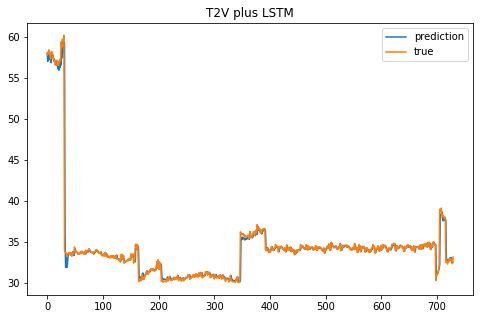

In [24]:

plt.figure(figsize=(8,5))

plt.plot(pred_t2v[:730], label='prediction')
plt.plot(y_test.ravel()[:730], label='true')
plt.title('T2V plus LSTM'); plt.legend()